In [1]:
import pandas as pd
data_path = "spam.csv"
df = pd.read_csv(data_path, encoding='latin-1')
# keep only needed columns if dataset has extras
df = df[['v1','v2']].rename(columns={'v1':'label','v2':'text'})
df.dropna(inplace=True)


In [2]:
print(df.shape)
print(df['label'].value_counts())
print(df['text'].str.len().describe())  # message length stats
# look at some examples
print(df.sample(5))

(5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64
count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: text, dtype: float64
     label                                               text
589    ham                 I'm in a meeting, call me later at
3587   ham  If you were/are free i can give. Otherwise nal...
4097   ham   I think just yourself Û_Thanks and see you tomo
1209   ham                        His bday real is in april .
1197   ham   He also knows about lunch menu only da. . I know


In [3]:
# label encoding
df['label_num'] = df['label'].apply(lambda x: 1 if str(x).strip().lower()=='spam' else 0)


In [4]:
# text cleaninng and preprocessing
import re
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+|https\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text_clean'] = df['text'].map(clean_text)


In [5]:
# train-test split
from sklearn.model_selection import train_test_split
X = df['text_clean']
y = df['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)


In [6]:
#Feature extraction — TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [7]:
# Train models (baseline)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

m_nb = MultinomialNB().fit(X_train_tfidf, y_train)
m_lr = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
m_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train_tfidf, y_train)



In [8]:
# evaluate models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate(model, Xt, yt):
    preds = model.predict(Xt)
    return {
        'accuracy': accuracy_score(yt, preds),
        'precision': precision_score(yt, preds, zero_division=0),
        'recall': recall_score(yt, preds, zero_division=0),
        'f1': f1_score(yt, preds, zero_division=0),
        'confusion': confusion_matrix(yt, preds)
    }

print("NB:", evaluate(m_nb, X_test_tfidf, y_test))
print("LR:", evaluate(m_lr, X_test_tfidf, y_test))
print("RF:", evaluate(m_rf, X_test_tfidf, y_test))


NB: {'accuracy': 0.968609865470852, 'precision': 1.0, 'recall': 0.7651006711409396, 'f1': 0.8669201520912547, 'confusion': array([[966,   0],
       [ 35, 114]])}
LR: {'accuracy': 0.9695067264573991, 'precision': 1.0, 'recall': 0.7718120805369127, 'f1': 0.8712121212121212, 'confusion': array([[966,   0],
       [ 34, 115]])}
RF: {'accuracy': 0.9757847533632287, 'precision': 1.0, 'recall': 0.8187919463087249, 'f1': 0.9003690036900369, 'confusion': array([[966,   0],
       [ 27, 122]])}


In [12]:
from sklearn.linear_model import LogisticRegression

m_best = LogisticRegression(max_iter=1000, class_weight='balanced')
m_best.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

preds = m_best.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))
print("F1:", f1_score(y_test, preds))


Accuracy: 0.9757847533632287
Precision: 0.9121621621621622
Recall: 0.9060402684563759
F1: 0.9090909090909091


In [15]:
import joblib

joblib.dump(m_best, "best_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

In [17]:
pred_counts = pd.Series(preds).value_counts().sort_index()


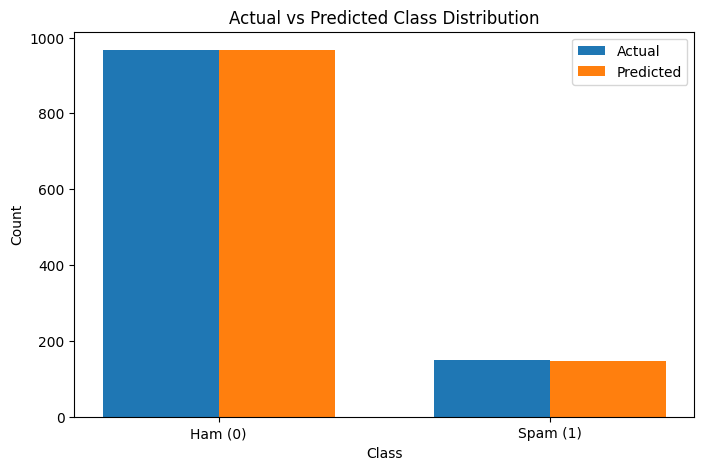

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Actual counts
actual_counts = y_test.value_counts().sort_index()

# Predicted counts (fixed)
pred_counts = pd.Series(preds).value_counts().sort_index()

labels = ['Ham (0)', 'Spam (1)']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, actual_counts, width, label='Actual')
plt.bar(x + width/2, pred_counts, width, label='Predicted')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Actual vs Predicted Class Distribution')
plt.xticks(x, labels)
plt.legend()
plt.show()


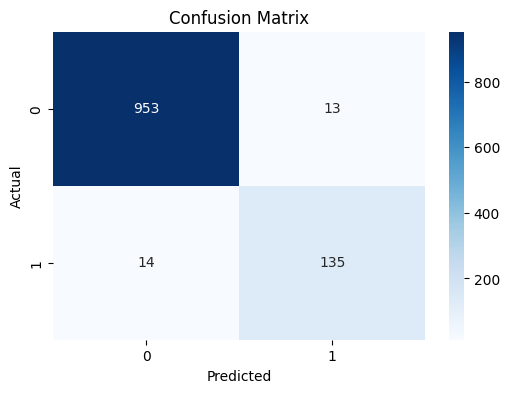

In [ ]:
#confution matrix heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# conclusion

The email spam detection model was successfully built using machine learning and
TF-IDF text vectorization. Logistic Regression performed well, achieving high accuracy
and effectively distinguishing between spam and ham messages. The confusion matrix
and class distribution graphs show that the model correctly identified most messages,
with very few misclassifications. Therefore, the model is reliable for basic spam
detection tasks and demonstrates the effectiveness of machine learning in text
classification.
